# Dynamic Analysis in Zebrafish Neural Crest Development

This tutorial provides a step-by-step workflow for analyzing transcriptional dynamics in our newly sequenced zebrafish Smart-seq3 dataset, focused on neural crest cell development. Leveraging state-of-the-art tools such as `scvelo` [[Bergen *et al*., 2020](https://www.nature.com/articles/s41587-020-0591-3), [La Manno *et al*., 2018](https://www.nature.com/articles/s41586-018-0414-6)] and `cellrank` [[Lange *et al*., 2022](https://www.nature.com/articles/s41592-021-01346-6), [Weiler *et al*., 2024](https://www.nature.com/articles/s41592-024-02303-9), [Reuter *et al*., 2019](https://pubs.aip.org/aip/jcp/article/150/17/174103/198585/Generalized-Markov-modeling-of-nonreversible)], this guide centers on the use of the `regvelo` package to model RNA velocity with gene regulatory priors.

We walk through the complete pipeline, from data preprocessing to model training and transcription factor perturbation analysis. The goal is to uncover key regulators and dynamic processes shaping neural crest development, providing a reproducible framework for applying `regvelo` to similar single-cell transcriptomics studies.

### Library import

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch

import cellrank as cr
import scvi

import mplscience
import matplotlib.pyplot as plt
import seaborn as sns

from regvelo import REGVELOVI
import regvelo as rgv

from scipy.stats import ttest_rel
import alphashape

/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
scvi.settings.seed = 0

[rank: 0] Seed set to 0


In [3]:
%matplotlib inline

In [4]:
plt.rcParams["svg.fonttype"] = "none"
scv.settings.set_figure_params("scvelo", dpi=100, transparent=True, fontsize=14, color_map="viridis")

### Define functions and constants

In [5]:
def normalized_sigmoid(x, k=5):
    sigmoid = lambda z: 1 / (1 + np.exp(-z))
    return (sigmoid(k * x) - sigmoid(-k)) / (sigmoid(k) - sigmoid(-k))

In [6]:
SIGNIFICANCE_PALETTE = {"n.s.": "#dedede", 
                        "*": "#90BAAD", 
                        "**": "#A1E5AB", 
                        "***": "#ADF6B1"}

### Load data

In [7]:
adata = rgv.datasets.zebrafish_nc()
prior_net = rgv.datasets.zebrafish_grn()
TF_list = adata.var_names[adata.var["is_tf"]].tolist()

In [8]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)
scv.pp.moments(adata)

2025-06-14 10:26:47.163998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749889607.375542 2966419 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749889607.512299 2966419 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749889608.013325 2966419 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749889608.013351 2966419 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749889608.013354 2966419 computation_placer.cc:177] computation placer alr

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


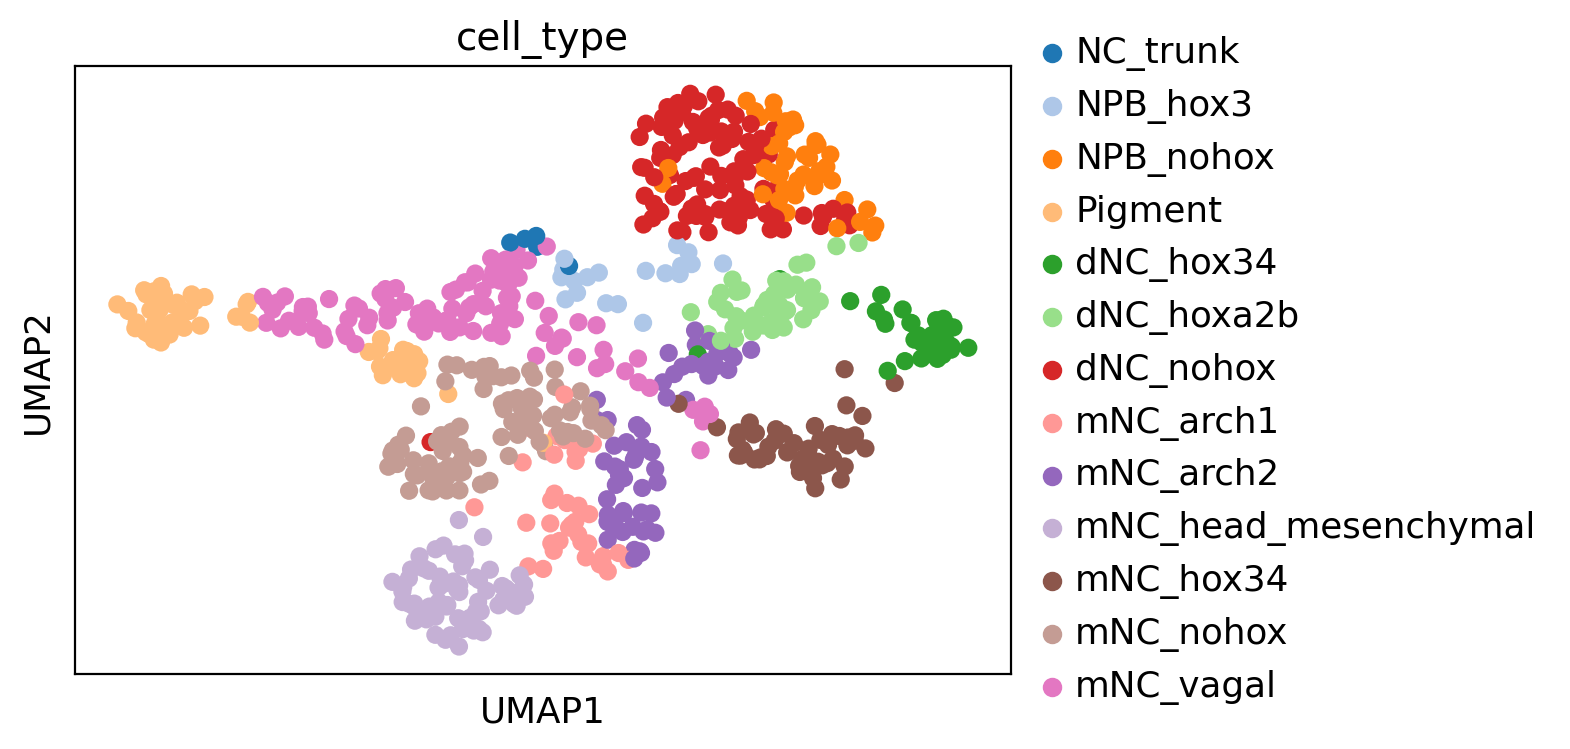

In [9]:
sc.pl.umap(adata, color='cell_type', palette=sc.pl.palettes.vega_20)

### Preprocessing

In [10]:
adata = rgv.pp.preprocess_data(adata)
adata = rgv.pp.set_prior_grn(adata, prior_net.T)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [11]:
TF_list = set(TF_list).intersection(adata.var_names)
TF_list = list(TF_list)
print("final number of TFs: " + str(len(TF_list)))

final number of TFs: 81


In [12]:
W = adata.uns["skeleton"].copy()
W = torch.tensor(np.array(W))

In [13]:
sparsity = W.sum() / ((W.sum(1) != 0).sum() * W.shape[0])
print("network sparsity: " + str(np.array(sparsity)))

network sparsity: 0.052775327


## Train RegVelo model

In [14]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae = REGVELOVI(adata, W=W.T, regulators=TF_list, soft_constraint=False)

In [15]:
reg_vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/light

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2377.829. Signaling Trainer to stop.


In [16]:
adata = reg_vae.add_regvelo_outputs_to_adata(adata=adata)
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/128 cores)


  0%|          | 0/697 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


## Predict terminal states

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

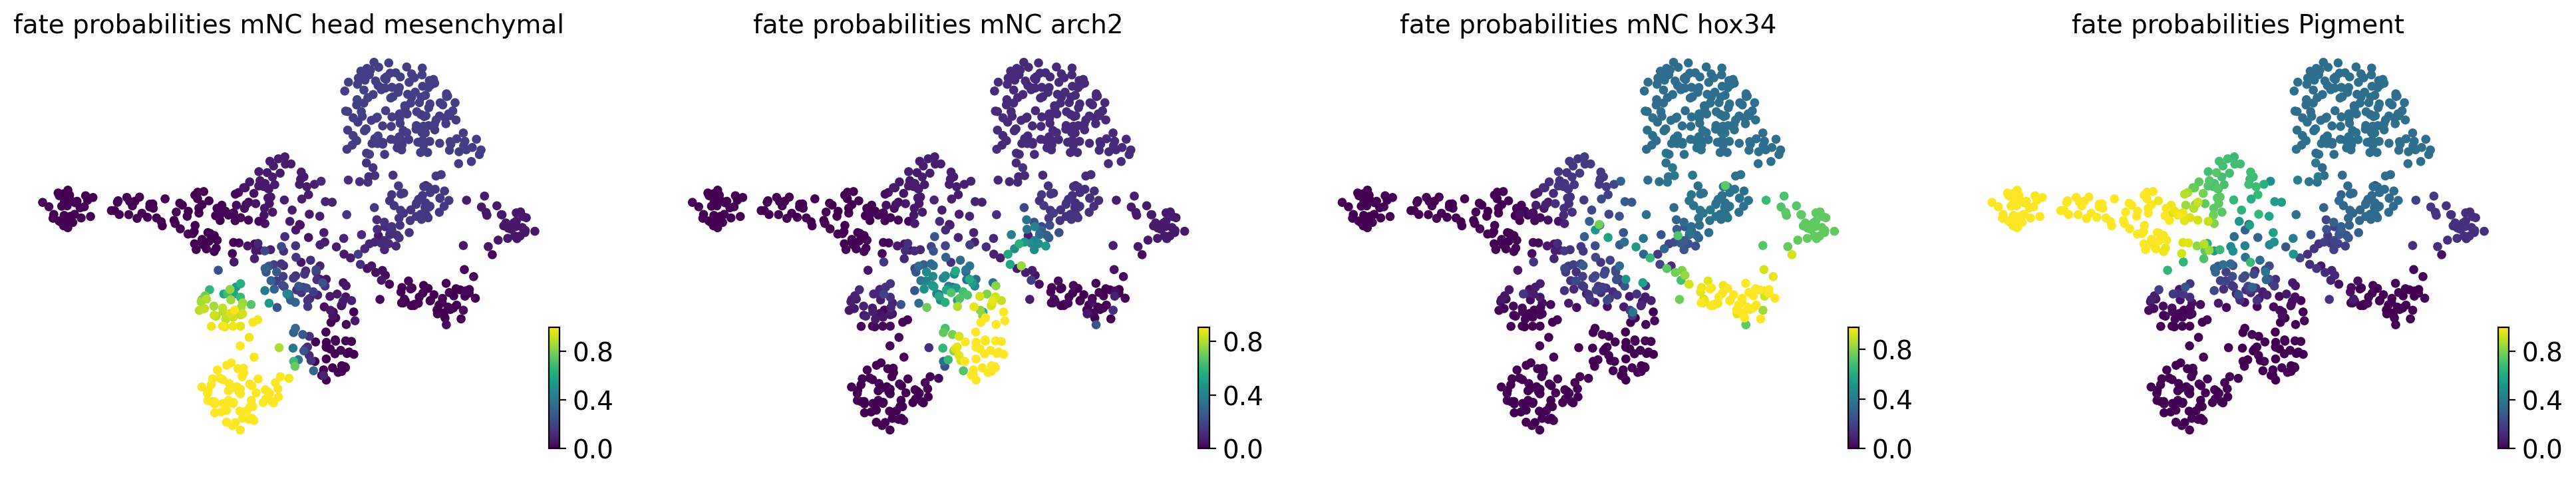

In [17]:
TERMINAL_STATE = ["mNC_head_mesenchymal",
                  "mNC_arch2",
                  "mNC_hox34",
                  "Pigment",
                 ]
vk = cr.kernels.VelocityKernel(adata).compute_transition_matrix()
estimator = cr.estimators.GPCCA(vk)

## evaluate the fate prob on original space
estimator.compute_macrostates(n_states=7, cluster_key="cell_type")
estimator.set_terminal_states(TERMINAL_STATE)
estimator.compute_fate_probabilities()
estimator.plot_fate_probabilities(same_plot=False)

/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/scvelo/plotting/utils.py:1396: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/scvelo/plotting/utils.py:1397: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


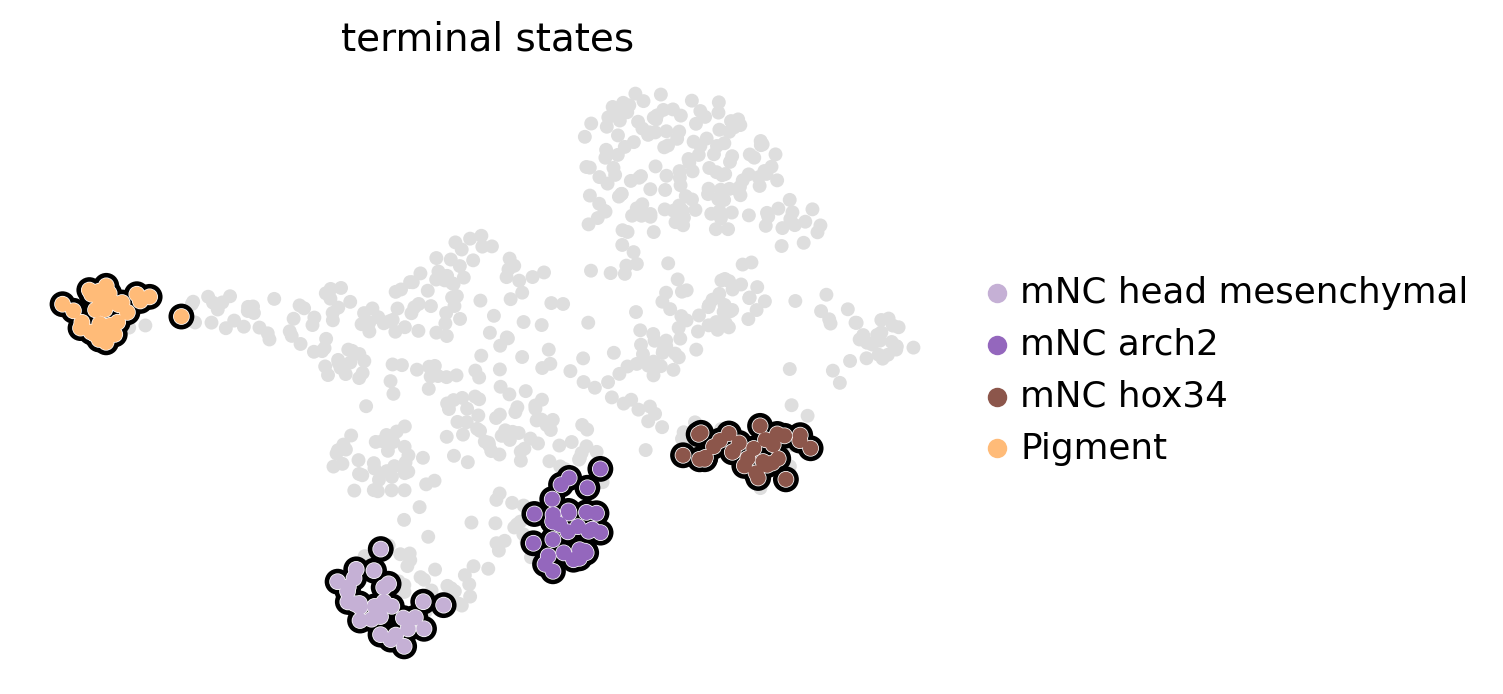

In [18]:
estimator.plot_macrostates(which="terminal", legend_loc="right", s=100)

### Save model

In [19]:
reg_vae.save("rgv_model")

## Perform perturbation screening

In the perturbation screening step, RegVelo enables users to generate a perturbed vector matrix, which is stored in `adata_target_perturb.layers["velocity"]`. This is then used to construct a new [CellRank](https://www.nature.com/articles/s41592-021-01346-6) kernel, which results in an updated estimate of perturbed cell fate prpobabilities.

We evalute the perturbation effects using two approaches:
<br>
(a) by comparing cell fate probabilities before and after perturbation, and 
<br>
(b) by simulating cell transitions using a Markov chain based on transition matrices inferred from the velocity fields of the unperturbed and perturbed systems.

Let $m$ denote the number of terminal states and $N_C$ the number of cells. For approach (a), we define the *depletion likelihood* to a terminal state $k$ as the normalized Mann-Whitney $U$ statistic 

\begin{equation}
l_d = \frac{1}{N_c^2} \sum_{n=1}^{N_C} \sum_{n^*=1}^{N_C} \mathbb{I} (\Pi_{:,k}(n) > \Pi_{:,k}^*(n^*)),
\end{equation}

where $\mathbb{I}$ is the indicator function and $\Pi, \ \Pi^* \in \mathbb{R}^{N_c \times m}$ are the control and perturbed cell fate probability matrices, respectively. 
For a terminal state $k$, a depletion likelihood $l_d > 0.5$ indicates a depletion effect in the perturbed system, as illustrated in Figure 1 (a). Using the depletion likelihood, we further define the depletion score as 
\begin{equation}
\Delta_d = 1-2 \cdot l_d.
\end{equation}

We have that $\Delta_d \in [-1,1]$, where $\Delta_d > 0$ indicates a long-term enrichment effect, whereas $\Delta_d < 0$ indicates a long-term depletion effect.

It is important to note that the depletion likelihood depends on the long-term fate probabilities of transient cells. In particular, a reduction in a transient cell’s probability of reaching one terminal state must be balanced by an increase in its probability of reaching other terminal states, since the row-wise sums of $\Pi$ and $\Pi^*$ are approximately 1. This redistribution can thus lead possible long-term enrichment effects in terminal states.

To capture short-term dynamics of the perturbed system, we also simulate the development of progenitor cells over a finite number of steps (``n_steps``) using Markov chain derived from the velocity-based transition matrices of both control and perturbed systems using the function ``rgv.tl.markov_density_simulation`` function. We then compare the frequency with which terminal cells are reached in both cases, quantifying depletion effects in short-term dynamics (Figure 1(b)). 

The Markov chain simulations can be run with either ``method='stepwise'`` (default) or ``method='one-step'``. The stepwise method simulates transitions one step at a time and terminates each trajectory either upon reaching a terminal cell or after ``n_steps``, whichever comes first. In contrast, the one-step method computes the cell state distribution after ``n_steps`` and draws samples directly from this distribution, without modeling intermediate transitions.

```{figure} _static/perturbation_metrics.svg
:width: 300
:name: fig-perturbation-effects
```

**Figure 1:** Visualization of perturbation effects.  
(a) Depletion likelihood $l_d$ where $\bar{\Pi}_{.k}$ and $\bar{\Pi}^*_{.k}$ denote mean cell fate probabilities.  
(b) Simulated Markov chain transitions of progenitor cells.

In the following, we demonstrate both perturbation quantification approaches for two perturbed models, in which we remove the transcription factors *nr2f5* and *elf1*, respectively.

Terminal states for the perturbed dynamics can be defined in two ways: Either by explicitly setting them via ``estimator.set_terminal_states(TERMINAL_STATE)``, or by reusing the terminal state indices identified in the original dynamics using [CellRank](https://www.nature.com/articles/s41592-021-01346-6).

### Long-term perturbation effect (Depletion likelihood based on cell fate probabilities)

In [20]:
adata_perturb_dict = {}
cand_list = ["nr2f5", "elf1"]

for TF in cand_list:
    model = 'rgv_model'
    adata_target_perturb, reg_vae_perturb =  rgv.tl.in_silico_block_simulation(model=model,
                                                                               adata=adata,
                                                                               TF=TF,
                                                                               cutoff=0)
    adata_perturb_dict[TF] = adata_target_perturb

INFO     File rgv_model/model.pt already downloaded                                                                
INFO     File rgv_model/model.pt already downloaded                                                                


In [21]:
df, adata_perturb_dict = rgv.mt.depletion_score(perturbed=adata_perturb_dict,
                                                baseline=adata,
                                                terminal_state=TERMINAL_STATE,
                                                n_states=7,
                                                cluster_key="cell_type")
df

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Fatal Python error: PyThreadState_Get: the function must be called with the GIL held, but the GIL is released (the current Python thread state is NULL)
Python runtime state: initialized

Current thread 0x00007f77e5323640 (most recent call first):
  File "/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/multiprocessing/connection.py", line 368 in _send
  File "/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/multiprocessing/connection.py", line 411 in _send_bytes
  File "/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/multiprocessing/connection.py", line 206 in send
  File "/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/multiprocessing/managers.py", line 216 in _handle_request
  File "/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/multiprocessing/managers.py", line 231 in handle_request
  File "/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/threading.py", line 953 in run
  File "/home/

  0%|          | 0/4 [00:00<?, ?/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

,Depletion score,p-value,FDR adjusted p-value,Terminal state,TF
0,-0.141654,0.000005,0.000019,mNC_head_mesenchymal,nr2f5
1,0.063718,0.039442,0.052589,mNC_arch2,nr2f5
2,0.081367,0.008538,0.017077,mNC_hox34,nr2f5
3,0.042661,0.167923,0.167923,Pigment,nr2f5
0,0.059639,0.053895,0.053895,mNC_head_mesenchymal,elf1
1,0.077292,0.012480,0.024960,mNC_arch2,elf1
2,0.064431,0.037291,0.049721,mNC_hox34,elf1
3,-0.093076,0.002626,0.010503,Pigment,elf1


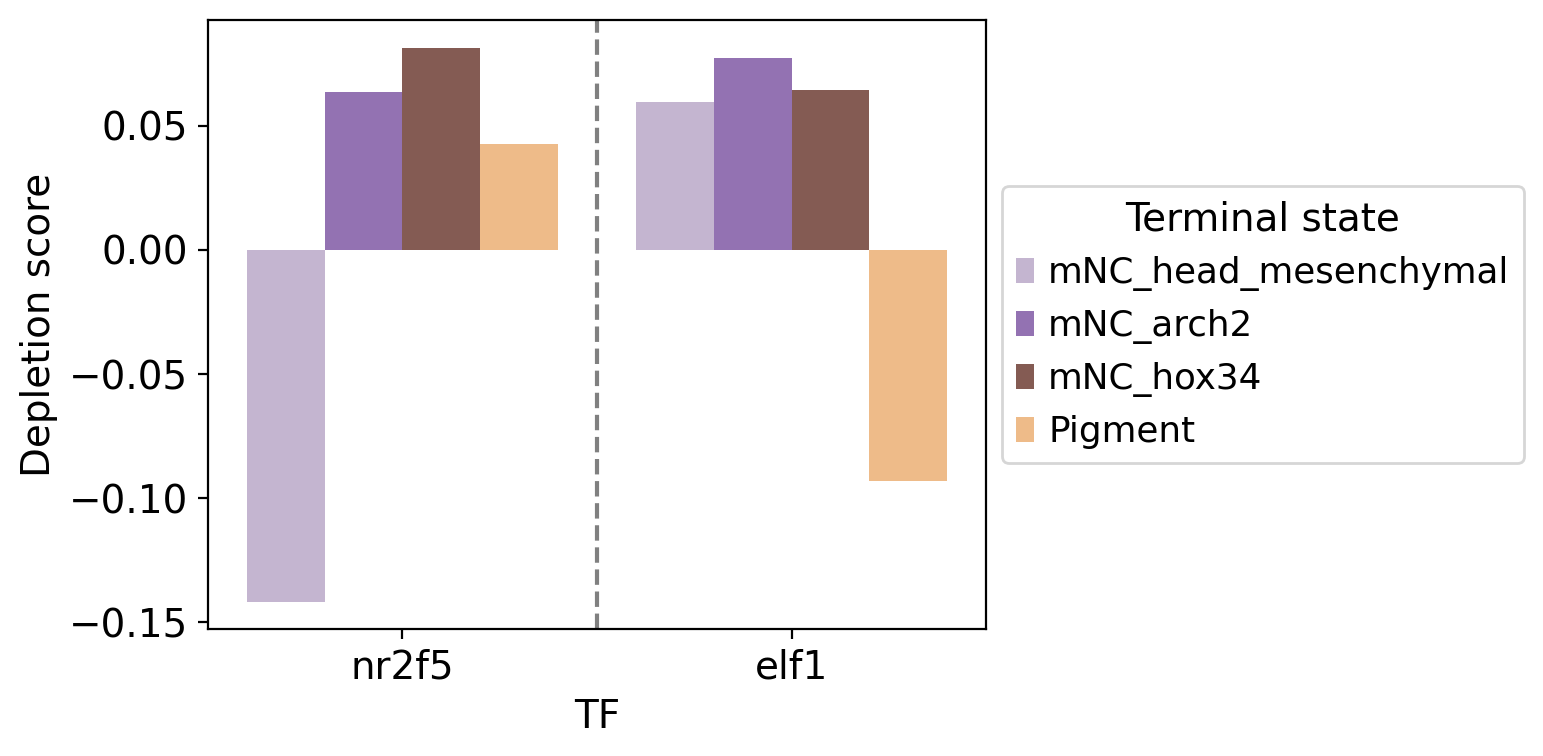

In [22]:
rgv.pl.depletion_score(adata=adata,
                       df=df,
                       fontsize=14,
                       figsize=(8, 4),
                       legend_loc='center left',
                       legend_bbox=(1.02, 0.5),
                       xlabel="TF",
                       ylabel="Depletion score",
                       color_label="cell_type"
                      )

By removing the TF *nr2f5*, one would expect a depletion of the cell type *mNC_head_mesenchymal* and an enrichment of the cell types *mNC_arch2*, *mNC_hox34*, and *Pigment* in the long run, compared to the control dynamics.

By removing the TF *elf1*, one would expect a depletion of the cell type *Pigment* and an enrichment of the cell types *mNC_head_mesenchymal*, *mNC_arch2*, and *mNC_hox34* in the long run, compared to the control dynamics.

For both models, we now have a look at their short-term perturbation effects and demonstrate both ``stepwise`` and ``one-step`` methods. Transition matrices are computed using [CellRank](https://www.nature.com/articles/s41592-021-01346-6) on the original and perturbed velocity fields.

### Short-term perturbation effect (Stochastic simulations of cell transitions)
For the Markov chain simulations, we note that the choice of ``n_steps`` in `rgv.tl.markov_density_simulation` can be made by evaluating the proportion of processes ending in a terminal cell using the control (unperturbed) cell state transition matrix. In this tutorial, we will use the default value ``n_steps=100``.

The function additionally takes as input ``n_simulations``, which determines the number of simulations to be performed for each cell. 

To compare the number of times each terminal cell is visited in the perturbed versus the control model, we compute the difference:
\begin{equation}
\frac{\# \text{visits in perturbed model} - \# \text{visits in control model}}{\# \text{total simulations}}.
\end{equation}

Negative values indicate a depletion effect in the corresponding terminal cell under the perturbed condition, while positive values suggest enrichment. To facilitate interpretation, we apply a normalized sigmoid function to map these values to the range $[0,1]$, such that negative differences correspond to values below 0.5 and positive differences to values above 0.5.

First, for each terminal state, we store the indices of the corresponding terminal cells in terminal_indices and compute the number of simulations in which the process ends in each of those cells. 

In [23]:
vkt = vk.transition_matrix.A
terminal_indices = np.where(adata.obs["term_states_fwd"].isin(TERMINAL_STATE))[0]

Next, we determine celltypes that do not belong to a terminal state and select cells with cell type labelled as *NPB_nhox*. This is predicted to be the initial state of the terminal states. We further set the number of simulations per initial cell to 1000 and the number of steps per simulation to 100.

In [24]:
start_states = np.unique(adata.obs["cell_type"])[[i not in TERMINAL_STATE for i in np.unique(adata.obs["cell_type"])]]
start_indices = np.where(adata.obs["cell_type"].isin(["NPB_nohox"]))[0]

n_simulations = 1000
n_steps = 100

#### Method 1: Stepwise simulations - *nr2f5* perturbation
We first consider the perturbed model by removing the TF *nr2f5*.

In [25]:
method = "stepwise"

TF = "nr2f5"
adata_perturb = adata_perturb_dict[TF]
adata_perturb.obs["cell_type"] = adata.obs["cell_type"].copy()

vk_p = cr.kernels.VelocityKernel(adata_perturb).compute_transition_matrix()
vkt_p = vk_p.transition_matrix.A

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

The function `rgv.tl.markov_density_simulation` returns both the absolute and relative number of visits for each terminal cell. The relative number of visits is also saved to `adata.obs[f"visits_{method}"]`.

In [26]:
control_visits_step, control_visits_dens_step = rgv.tl.markov_density_simulation(adata, 
                                                                                 vkt, 
                                                                                 start_indices, 
                                                                                 terminal_indices, 
                                                                                 TERMINAL_STATE,
                                                                                 n_steps=n_steps, 
                                                                                 n_simulations=n_simulations, 
                                                                                 method=method)

perturb_visits_step, perturb_visits_dens_step = rgv.tl.markov_density_simulation(adata_perturb, 
                                                                                 vkt_p, 
                                                                                 start_indices, 
                                                                                 terminal_indices, 
                                                                                 TERMINAL_STATE,
                                                                                 n_steps=n_steps, 
                                                                                 n_simulations=n_simulations, 
                                                                                 method=method)

Proportion of simulations reaching a terminal cell 0.3615744680851064
Proportion of simulations reaching a terminal cell 0.2126595744680851


We observe that, in the perturbed case, the overall proportion of simulations reaching a terminal cell within the fixed time period is lower compared to the control model. Specifically, 35.9% of simulations reach a terminal cell in the control model, whereas only 21.6% do so under perturbation.

In [27]:
adata.obs['visits_diff_step'] = np.nan
adata.obs['visits_diff_step'].iloc[terminal_indices] = adata_perturb.obs['visits_stepwise'].iloc[terminal_indices] - adata.obs['visits_stepwise'].iloc[terminal_indices]
adata.obs['visits_diff_sigmoid_step'] = np.nan
adata.obs['visits_diff_sigmoid_step'].iloc[terminal_indices] = normalized_sigmoid(adata.obs['visits_diff_step'].iloc[terminal_indices])

For plotting purposes, we only consider terminal cells.

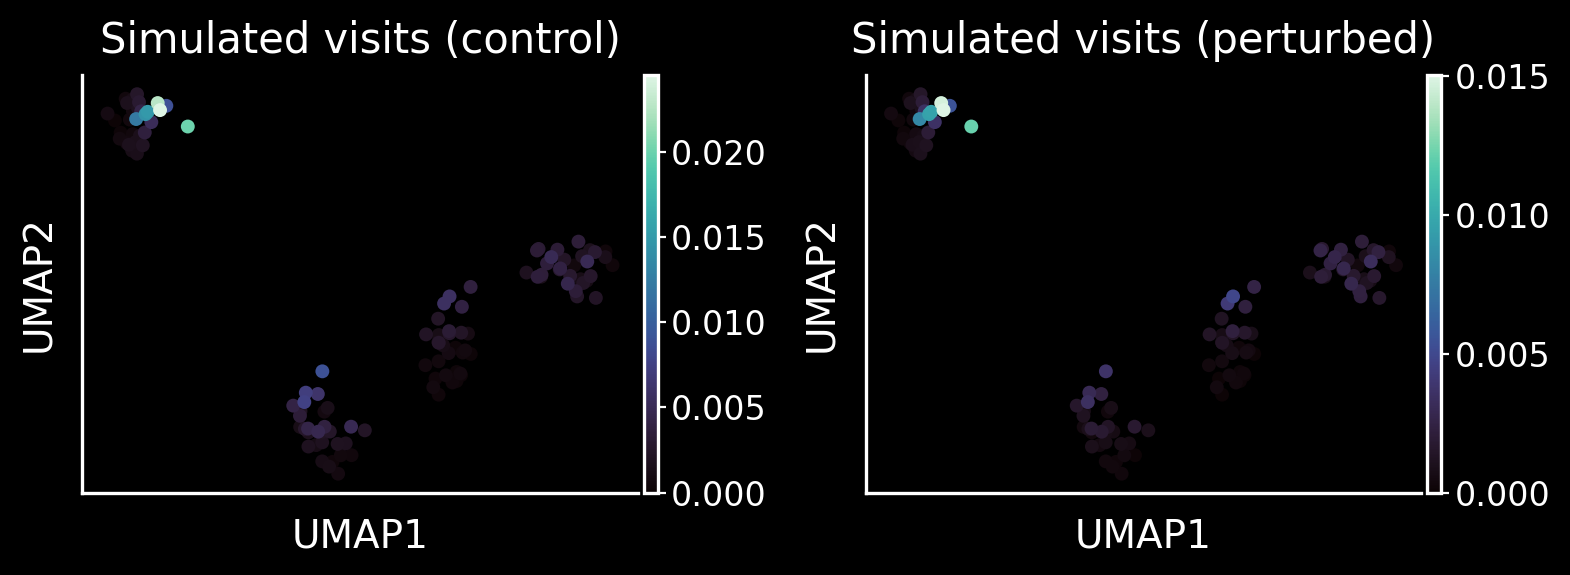

In [28]:
adata_plot = adata[adata.obs["term_states_fwd"].isin(TERMINAL_STATE)].copy()
adata_perturb_plot = adata_perturb[adata_perturb.obs["term_states_fwd"].isin(TERMINAL_STATE)].copy()

with mplscience.style_context():
    plt.style.use('dark_background')
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))

    for ax in axes:
        fig.patch.set_facecolor('black')
        ax.set_facecolor('black')
    
    sc.pl.umap(
        adata_plot,
        ax=axes[0],
        color=["visits_stepwise"],
        cmap="mako",
        vmin=0,
        show=False,
        s = 100,
    )
    axes[0].set_title("Simulated visits (control)")

    sc.pl.umap(
        adata_perturb_plot,
        ax=axes[1],
        color=["visits_stepwise"],
        cmap="mako",
        vmin=0,
        show=False,
        s = 100,
    )
    axes[1].set_title("Simulated visits (perturbed)")
    
    plt.tight_layout()
    plt.show()

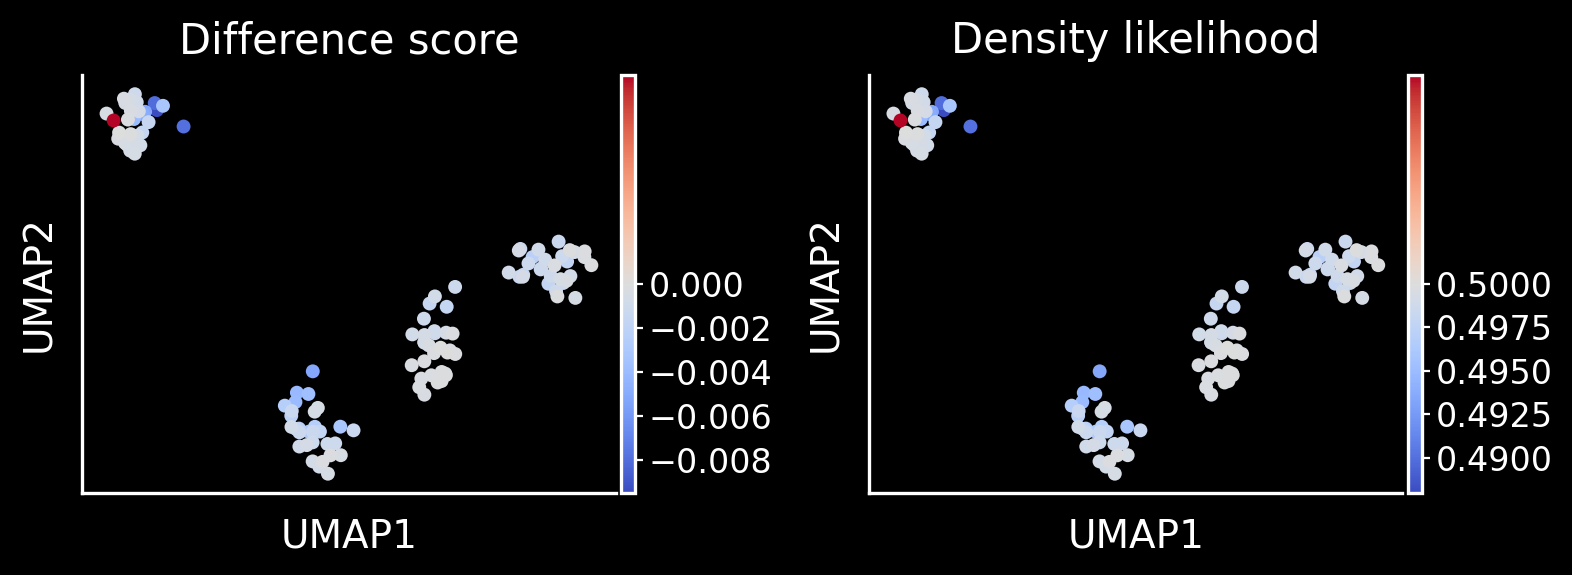

In [29]:
with mplscience.style_context():
    plt.style.use('dark_background')
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    
    for ax in axes:
        fig.patch.set_facecolor('black')
        ax.set_facecolor('black')
    
    sc.pl.umap(
        adata_plot,
        ax=axes[0],
        color=["visits_diff_step"],
        cmap="coolwarm",
        vcenter = 0,
        show=False,
        s = 100
    )
    axes[0].set_title("Difference score")

    sc.pl.umap(
        adata_plot,
        ax=axes[1],
        color=["visits_diff_sigmoid_step"],
        cmap="coolwarm",
        vcenter = 0.5,
        show=False,
        s=100
    )
    axes[1].set_title("Density likelihood")

    plt.tight_layout()
    plt.show()

We further perform a paired t-test to assess whether the mean number of visits to each terminal cell differs significantly between the perturbed and control models for each terminal state.

In [30]:
data = []
palette_rel = []

for ts in TERMINAL_STATE:
    terminal_indices_sub = np.where(adata.obs["term_states_fwd"].isin([ts]))[0]
    arrivals = adata.obs["visits_stepwise"].iloc[terminal_indices_sub]
    arrivals_p = adata_perturb.obs["visits_stepwise"].iloc[terminal_indices_sub]

    values = adata.obs["visits_diff_sigmoid_step"].iloc[terminal_indices_sub]
    subgroups = [ts]*(len(arrivals))

    for val, subgrp in zip(values, subgroups):
        data.append({"Value": val, "Group": subgrp})

    t_stat, p_value = ttest_rel(arrivals_p, arrivals)
    significance = rgv.mt.get_significance(p_value)
    print(f"{ts}: {p_value}")
    palette_rel.append(SIGNIFICANCE_PALETTE[significance])

df = pd.DataFrame(data)

mNC_head_mesenchymal: 1.0388254084002412e-07
mNC_arch2: 6.385268221500673e-07
mNC_hox34: 6.971348452267362e-10
Pigment: 0.0004889179271363851


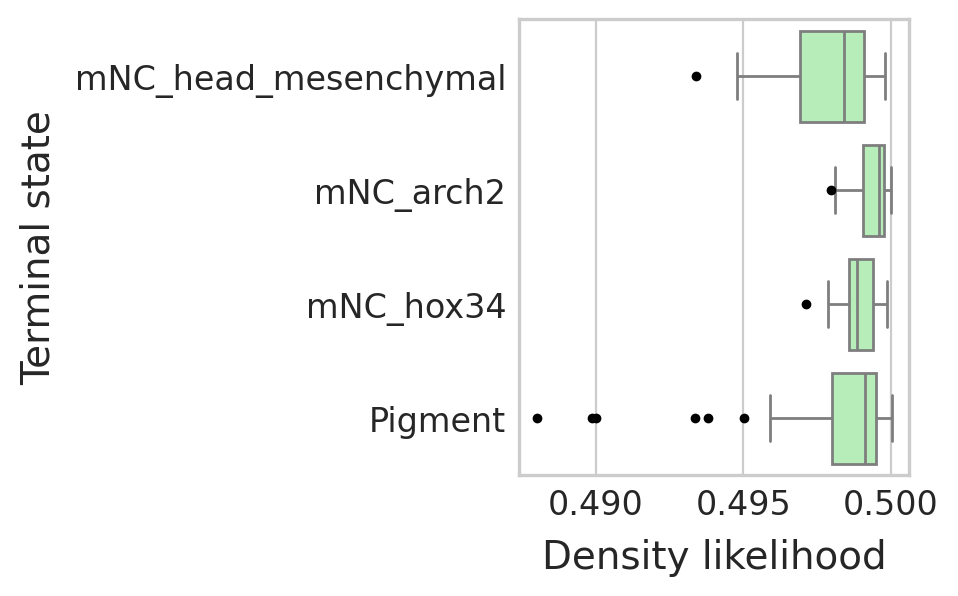

In [31]:
with mplscience.style_context():
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(2.5, 3))
    
    sns.boxplot(
        data=df,
        y="Group",
        x="Value",
        palette=palette_rel,
        ax=ax,
        flierprops={
            'marker': '.',
            'markersize': 5,
            'markerfacecolor': 'black',
            'markeredgecolor': 'black'
        }
    )
    ax.set_xlabel("Density likelihood")
    ax.set_ylabel("Terminal state")
    
    for spine in ax.spines.values():
        spine.set_visible(True)

    plt.show()

#### Method 1: Stepwise simulations - *elf1* perturbation
We now consider the perturbed model by removing the TF *elf1*. 

In [32]:
TF = "elf1"
adata_perturb = adata_perturb_dict[TF]
adata_perturb.obs["cell_type"] = adata.obs["cell_type"].copy()

vk_p = cr.kernels.VelocityKernel(adata_perturb).compute_transition_matrix()
vkt_p = vk_p.transition_matrix.A

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

In [33]:
control_visits_step, control_visits_dens_step = rgv.tl.markov_density_simulation(adata, 
                                                                                 vkt, 
                                                                                 start_indices, 
                                                                                 terminal_indices, 
                                                                                 TERMINAL_STATE,
                                                                                 n_steps=n_steps, 
                                                                                 n_simulations=n_simulations, 
                                                                                 method=method)

perturb_visits_step, perturb_visits_dens_step = rgv.tl.markov_density_simulation(adata_perturb, 
                                                                                 vkt_p, 
                                                                                 start_indices, 
                                                                                 terminal_indices, 
                                                                                 TERMINAL_STATE,
                                                                                 n_steps=n_steps, 
                                                                                 n_simulations=n_simulations, 
                                                                                 method=method)

Proportion of simulations reaching a terminal cell 0.3615744680851064
Proportion of simulations reaching a terminal cell 0.35861702127659567


We observe that the overall proportion of simulations reaching a terminal cell within the fixed time period is nearly unchanged between the perturbed and control models. Specifically, 35.9% of simulations reach a terminal cell in the control model, compared to 35.8% under perturbation.

This suggests that the perturbation may not affect the overall commitment rate within the simulated time period.

In [34]:
adata.obs['visits_diff_step'] = np.nan
adata.obs['visits_diff_step'].iloc[terminal_indices] = adata_perturb.obs['visits_stepwise'].iloc[terminal_indices] - adata.obs['visits_stepwise'].iloc[terminal_indices]
adata.obs['visits_diff_sigmoid_step'] = np.nan
adata.obs['visits_diff_sigmoid_step'].iloc[terminal_indices] = normalized_sigmoid(adata.obs['visits_diff_step'].iloc[terminal_indices])

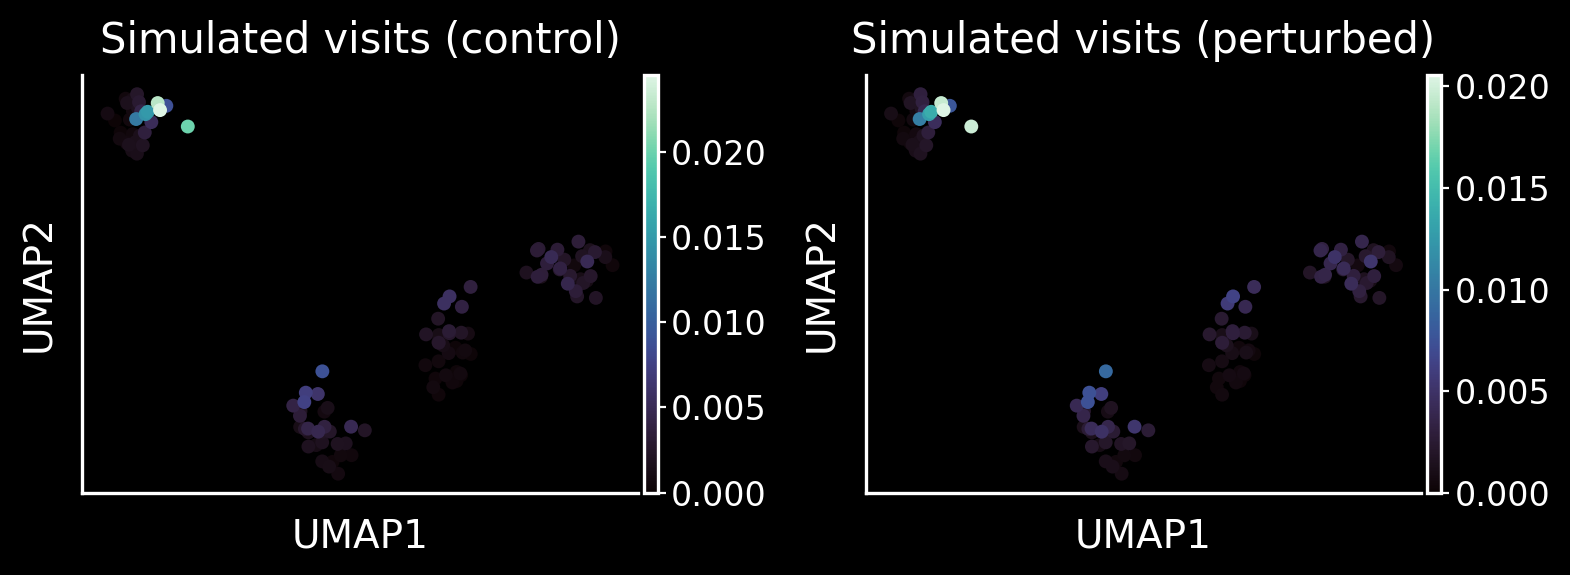

In [35]:
adata_plot = adata[adata.obs["term_states_fwd"].isin(TERMINAL_STATE)].copy()
adata_perturb_plot = adata_perturb[adata_perturb.obs["term_states_fwd"].isin(TERMINAL_STATE)].copy()

with mplscience.style_context():
    plt.style.use('dark_background')
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))

    for ax in axes:
        fig.patch.set_facecolor('black')
        ax.set_facecolor('black')
    
    sc.pl.umap(
        adata_plot,
        ax=axes[0],
        color=["visits_stepwise"],
        cmap="mako",
        vmin=0,
        show=False,
        s = 100,
    )
    axes[0].set_title("Simulated visits (control)")

    sc.pl.umap(
        adata_perturb_plot,
        ax=axes[1],
        color=["visits_stepwise"],
        cmap="mako",
        vmin=0,
        show=False,
        s = 100,
    )
    axes[1].set_title("Simulated visits (perturbed)")
    
    plt.tight_layout()
    plt.show()

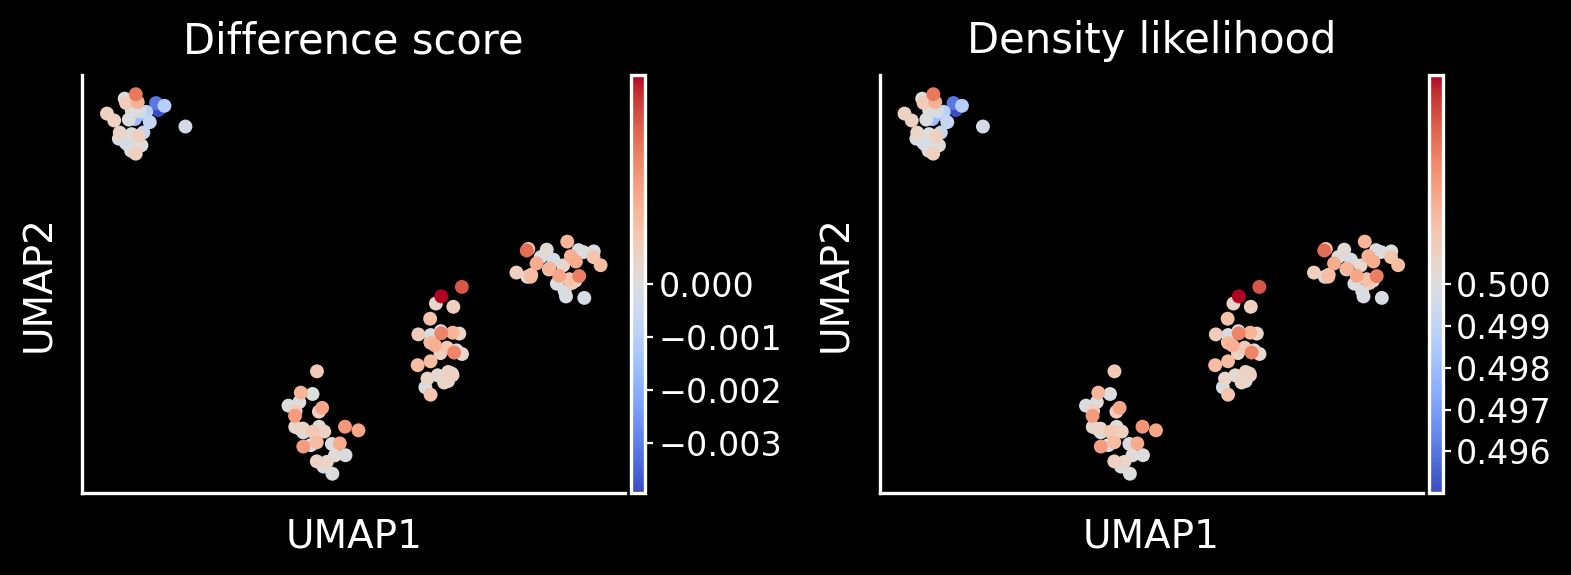

In [36]:
with mplscience.style_context():
    plt.style.use('dark_background')
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    
    for ax in axes:
        fig.patch.set_facecolor('black')
        ax.set_facecolor('black')
    
    sc.pl.umap(
        adata_plot,
        ax=axes[0],
        color=["visits_diff_step"],
        cmap="coolwarm",
        vcenter = 0,
        show=False,
        s = 100
    )
    axes[0].set_title("Difference score")

    sc.pl.umap(
        adata_plot,
        ax=axes[1],
        color=["visits_diff_sigmoid_step"],
        cmap="coolwarm",
        vcenter = 0.5,
        show=False,
        s=100
    )
    axes[1].set_title("Density likelihood")

    plt.tight_layout()
    plt.show()

In [37]:
data = []
palette_rel = []

for ts in TERMINAL_STATE:
    terminal_indices_sub = np.where(adata.obs["term_states_fwd"].isin([ts]))[0]
    arrivals = adata.obs["visits_stepwise"].iloc[terminal_indices_sub]
    arrivals_p = adata_perturb.obs["visits_stepwise"].iloc[terminal_indices_sub]

    values = adata.obs["visits_diff_sigmoid_step"].iloc[terminal_indices_sub]
    subgroups = [ts]*(len(arrivals))

    for val, subgrp in zip(values, subgroups):
        data.append({"Value": val, "Group": subgrp})

    t_stat, p_value = ttest_rel(arrivals_p, arrivals)
    significance = rgv.mt.get_significance(p_value)
    print(f"{ts}: {p_value}")
    palette_rel.append(SIGNIFICANCE_PALETTE[significance])

df = pd.DataFrame(data)

mNC_head_mesenchymal: 0.002008393908970598
mNC_arch2: 0.0008743624255374146
mNC_hox34: 0.004047887217802147
Pigment: 0.01323945105367373


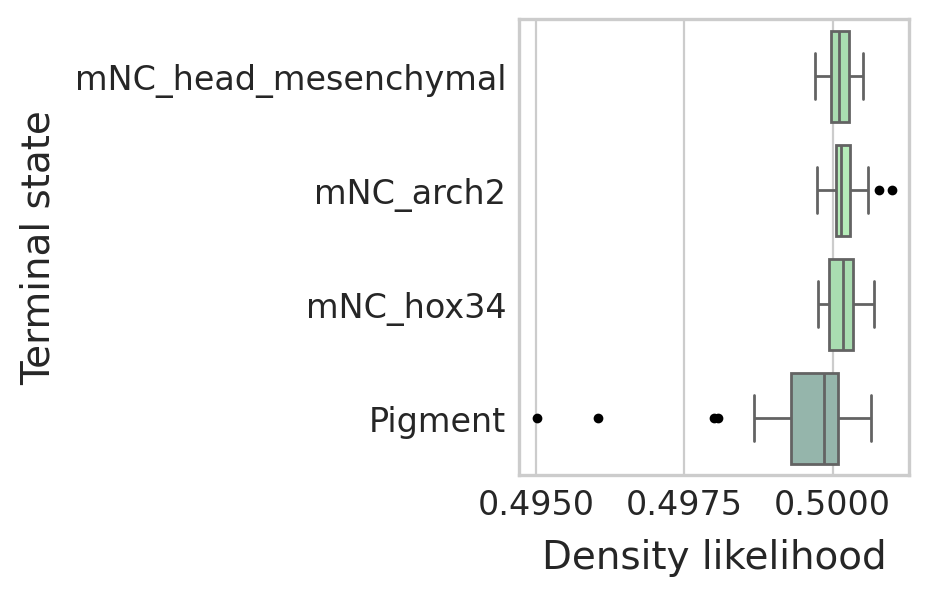

In [38]:
with mplscience.style_context():
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(2.5, 3))
    
    sns.boxplot(
        data=df,
        y="Group",
        x="Value",
        palette=palette_rel,
        ax=ax,
        flierprops={
            'marker': '.',
            'markersize': 5,
            'markerfacecolor': 'black',
            'markeredgecolor': 'black'
        }
    )
    ax.set_xlabel("Density likelihood")
    ax.set_ylabel("Terminal state")
    
    for spine in ax.spines.values():
        spine.set_visible(True)

    plt.show()

We now repeat the above steps by sampling directly from the cell state distribution after ``n_steps`` steps.

#### Method 2: One-step simulations - *nr2f5* perturbation

In [39]:
method = "one-step"

TF = "nr2f5"
adata_perturb = adata_perturb_dict[TF]
adata_perturb.obs["cell_type"] = adata.obs["cell_type"].copy()

vk_p = cr.kernels.VelocityKernel(adata_perturb).compute_transition_matrix()
vkt_p = vk_p.transition_matrix.A

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

In [40]:
control_visits_one, control_visits_dens_one = rgv.tl.markov_density_simulation(adata, 
                                                                               vkt, 
                                                                               start_indices, 
                                                                               terminal_indices, 
                                                                               TERMINAL_STATE,
                                                                               n_steps=n_steps, 
                                                                               n_simulations=n_simulations, 
                                                                               method=method)

perturb_visits_one, perturb_visits_dens_one = rgv.tl.markov_density_simulation(adata_perturb, 
                                                                               vkt_p, 
                                                                               start_indices, 
                                                                               terminal_indices, 
                                                                               TERMINAL_STATE,
                                                                               n_steps=n_steps, 
                                                                               n_simulations=n_simulations, 
                                                                               method=method)

Proportion of simulations reaching a terminal cell 0.32974468085106384
Proportion of simulations reaching a terminal cell 0.19395744680851065


We observe that, in the perturbed case, the overall proportion of simulations reaching a terminal cell within the fixed time period is lower compared to the control model. Specifically, 32.8% of simulations reach a terminal cell in the control model, whereas only 19.3% do so under perturbation.

However, both values are slightly lower than those obtained using the stepwise method, suggesting that some cells that reached a terminal state within `n_steps` may have subsequently exited the terminal state when using the one-step method.

In [41]:
adata.obs['visits_diff_one'] = np.nan
adata.obs['visits_diff_one'].iloc[terminal_indices] = adata_perturb.obs['visits_one-step'].iloc[terminal_indices] - adata.obs['visits_one-step'].iloc[terminal_indices]
adata.obs['visits_diff_sigmoid_one'] = np.nan
adata.obs['visits_diff_sigmoid_one'].iloc[terminal_indices] = normalized_sigmoid(adata.obs['visits_diff_one'].iloc[terminal_indices])

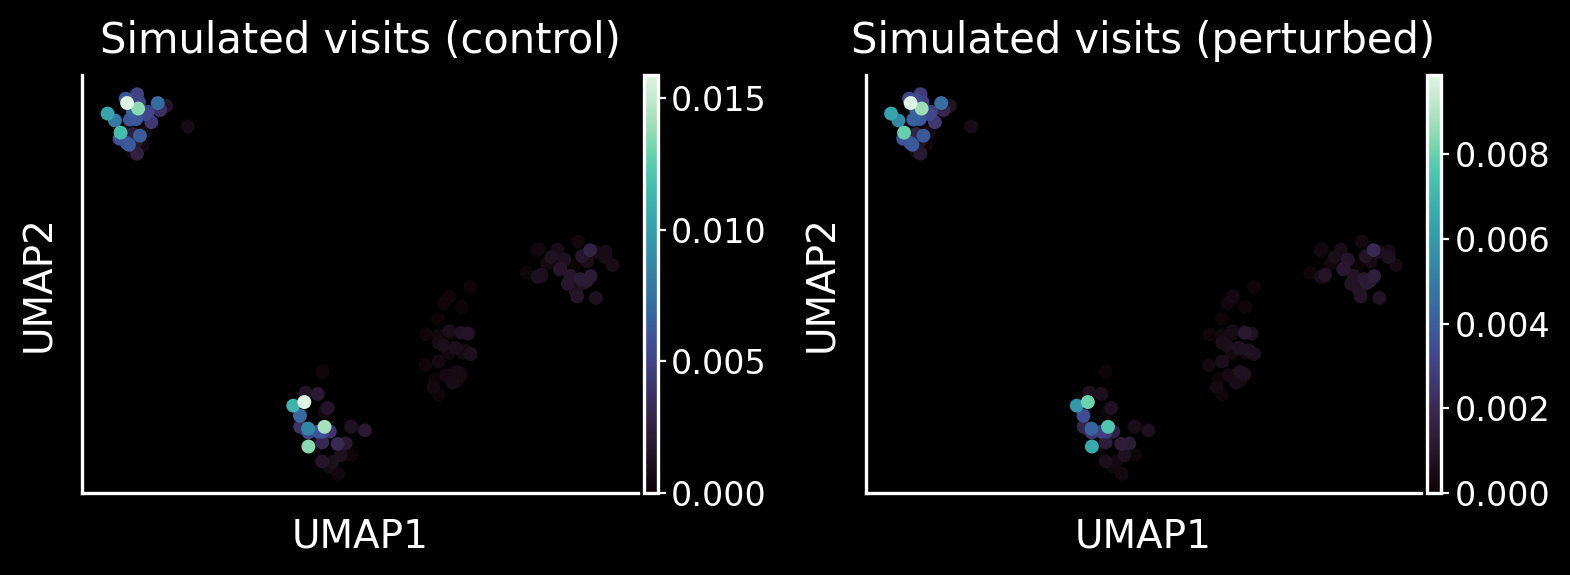

In [42]:
adata_plot = adata[adata.obs["term_states_fwd"].isin(TERMINAL_STATE)].copy()
adata_perturb_plot = adata_perturb[adata_perturb.obs["term_states_fwd"].isin(TERMINAL_STATE)].copy()

with mplscience.style_context():
    plt.style.use('dark_background')
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))

    for ax in axes:
        fig.patch.set_facecolor('black')
        ax.set_facecolor('black')
    
    sc.pl.umap(
        adata_plot,
        ax=axes[0],
        color=["visits_one-step"],
        cmap="mako",
        vmin=0,
        show=False,
        s = 100,
    )
    axes[0].set_title("Simulated visits (control)")

    sc.pl.umap(
        adata_perturb_plot,
        ax=axes[1],
        color=["visits_one-step"],
        cmap="mako",
        vmin=0,
        show=False,
        s = 100,
    )
    axes[1].set_title("Simulated visits (perturbed)")
    
    plt.tight_layout()
    plt.show()

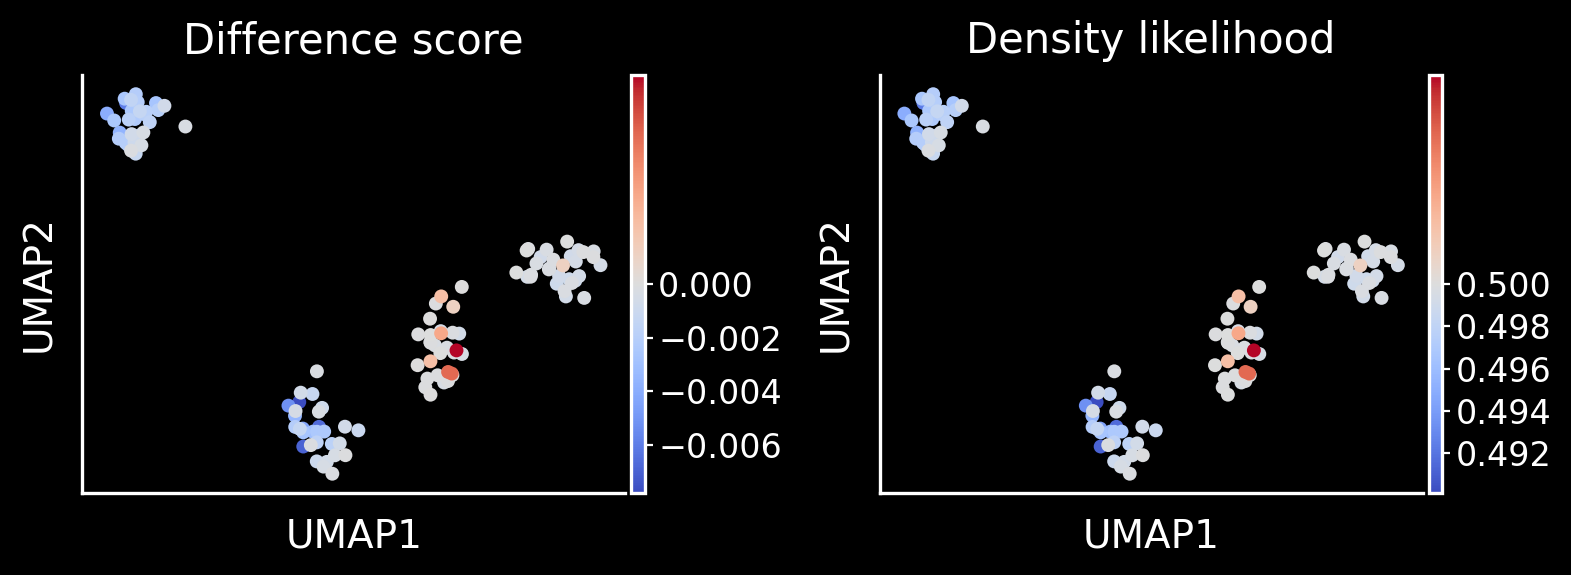

In [43]:
with mplscience.style_context():
    plt.style.use('dark_background')
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    
    for ax in axes:
        fig.patch.set_facecolor('black')
        ax.set_facecolor('black')
    
    sc.pl.umap(
        adata_plot,
        ax=axes[0],
        color=["visits_diff_one"],
        cmap="coolwarm",
        vcenter = 0,
        show=False,
        s = 100
    )
    axes[0].set_title("Difference score")

    sc.pl.umap(
        adata_plot,
        ax=axes[1],
        color=["visits_diff_sigmoid_one"],
        cmap="coolwarm",
        vcenter = 0.5,
        show=False,
        s=100
    )
    axes[1].set_title("Density likelihood")

    plt.tight_layout()
    plt.show()

In [44]:
data = []
palette_rel = []

for ts in TERMINAL_STATE:
    terminal_indices_sub = np.where(adata.obs["term_states_fwd"].isin([ts]))[0]
    arrivals = adata.obs["visits_one-step"].iloc[terminal_indices_sub]
    arrivals_p = adata_perturb.obs["visits_one-step"].iloc[terminal_indices_sub]

    values = adata.obs["visits_diff_sigmoid_one"].iloc[terminal_indices_sub]
    subgroups = [ts]*(len(arrivals))

    for val, subgrp in zip(values, subgroups):
        data.append({"Value": val, "Group": subgrp})

    t_stat, p_value = ttest_rel(arrivals_p, arrivals)
    significance = rgv.mt.get_significance(p_value)
    print(f"{ts}: {p_value}")
    palette_rel.append(SIGNIFICANCE_PALETTE[significance])

df = pd.DataFrame(data)

mNC_head_mesenchymal: 1.83419347458315e-05
mNC_arch2: 0.006290120629851755
mNC_hox34: 3.731241368483132e-08
Pigment: 2.9413421676245077e-09


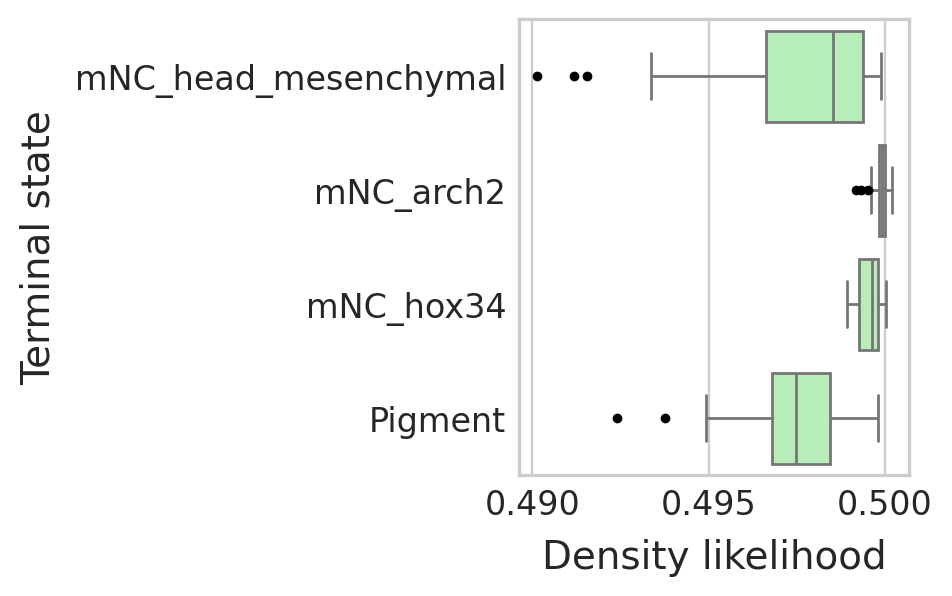

In [45]:
with mplscience.style_context():
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(2.5, 3))
    
    sns.boxplot(
        data=df,
        y="Group",
        x="Value",
        palette=palette_rel,
        ax=ax,
        flierprops={
            'marker': '.',
            'markersize': 5,
            'markerfacecolor': 'black',
            'markeredgecolor': 'black'
        }
    )
    ax.set_xlabel("Density likelihood")
    ax.set_ylabel("Terminal state")
    
    for spine in ax.spines.values():
        spine.set_visible(True)

    plt.show()

#### Method 2: One-step simulations - *elf1* perturbation

In [46]:
TF = "elf1"
adata_perturb = adata_perturb_dict[TF]
adata_perturb.obs["cell_type"] = adata.obs["cell_type"].copy()

vk_p = cr.kernels.VelocityKernel(adata_perturb).compute_transition_matrix()
vkt_p = vk_p.transition_matrix.A

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

In [47]:
control_visits_one, control_visits_dens_one = rgv.tl.markov_density_simulation(adata, 
                                                                               vkt, 
                                                                               start_indices, 
                                                                               terminal_indices, 
                                                                               TERMINAL_STATE,
                                                                               n_steps=n_steps, 
                                                                               n_simulations=n_simulations, 
                                                                               method=method)

perturb_visits_one, perturb_visits_dens_one = rgv.tl.markov_density_simulation(adata_perturb, 
                                                                               vkt_p, 
                                                                               start_indices, 
                                                                               terminal_indices, 
                                                                               TERMINAL_STATE,
                                                                               n_steps=n_steps, 
                                                                               n_simulations=n_simulations, 
                                                                               method=method)

Proportion of simulations reaching a terminal cell 0.32974468085106384
Proportion of simulations reaching a terminal cell 0.32438297872340427


Similar as in the stepwise method, we observe that the overall proportion of simulations reaching a terminal cell within the fixed time period is nearly unchanged between the perturbed and control models. Specifically, 32.8% of simulations reach a terminal cell in the control model, compared to 32.3% under perturbation.

This suggests that the perturbation may not affect the overall commitment rate within the simulated time period.

Also in this case, both values are slightly lower than those obtained using the stepwise method, suggesting that some cells that reached a terminal state within `n_steps` may have subsequently exited the terminal state when using the one-step method.

In [48]:
adata.obs['visits_diff_one'] = np.nan
adata.obs['visits_diff_one'].iloc[terminal_indices] = adata_perturb.obs['visits_one-step'].iloc[terminal_indices] - adata.obs['visits_one-step'].iloc[terminal_indices]
adata.obs['visits_diff_sigmoid_one'] = np.nan
adata.obs['visits_diff_sigmoid_one'].iloc[terminal_indices] = normalized_sigmoid(adata.obs['visits_diff_one'].iloc[terminal_indices])

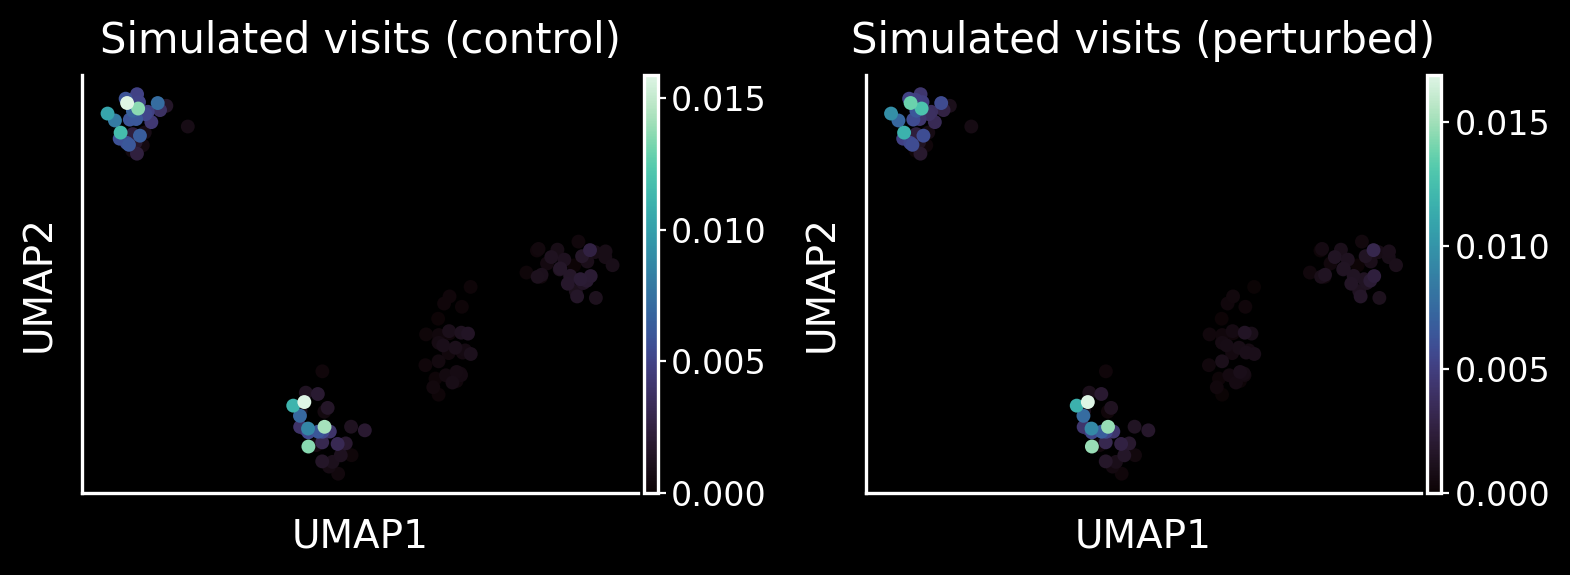

In [49]:
adata_plot = adata[adata.obs["term_states_fwd"].isin(TERMINAL_STATE)].copy()
adata_perturb_plot = adata_perturb[adata_perturb.obs["term_states_fwd"].isin(TERMINAL_STATE)].copy()

with mplscience.style_context():
    plt.style.use('dark_background')
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))

    for ax in axes:
        fig.patch.set_facecolor('black')
        ax.set_facecolor('black')
    
    sc.pl.umap(
        adata_plot,
        ax=axes[0],
        color=["visits_one-step"],
        cmap="mako",
        vmin=0,
        show=False,
        s = 100,
    )
    axes[0].set_title("Simulated visits (control)")

    sc.pl.umap(
        adata_perturb_plot,
        ax=axes[1],
        color=["visits_one-step"],
        cmap="mako",
        vmin=0,
        show=False,
        s = 100,
    )
    axes[1].set_title("Simulated visits (perturbed)")
    
    plt.tight_layout()
    plt.show()

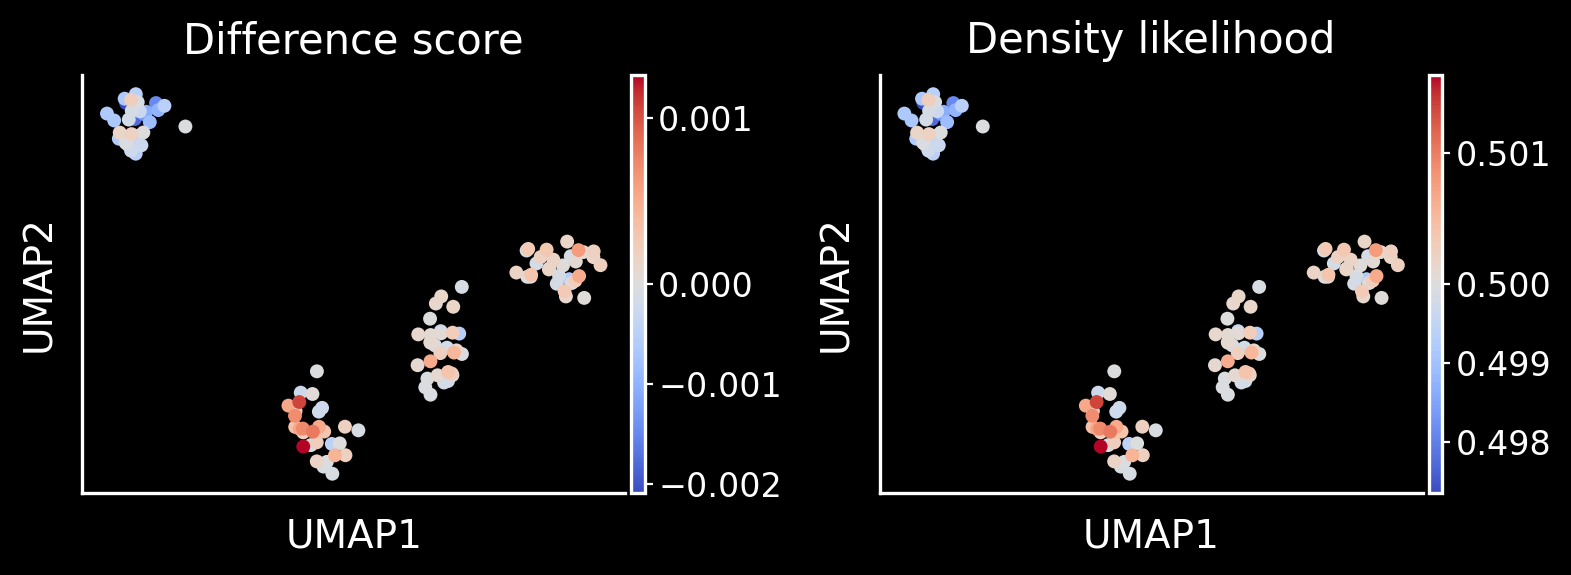

In [50]:
with mplscience.style_context():
    plt.style.use('dark_background')
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    
    for ax in axes:
        fig.patch.set_facecolor('black')
        ax.set_facecolor('black')
    
    sc.pl.umap(
        adata_plot,
        ax=axes[0],
        color=["visits_diff_one"],
        cmap="coolwarm",
        vcenter = 0,
        show=False,
        s = 100
    )
    axes[0].set_title("Difference score")

    sc.pl.umap(
        adata_plot,
        ax=axes[1],
        color=["visits_diff_sigmoid_one"],
        cmap="coolwarm",
        vcenter = 0.5,
        show=False,
        s=100
    )
    axes[1].set_title("Density likelihood")

    plt.tight_layout()
    plt.show()

In [51]:
data = []
palette_rel = []

for ts in TERMINAL_STATE:
    terminal_indices_sub = np.where(adata.obs["term_states_fwd"].isin([ts]))[0]
    arrivals = adata.obs["visits_one-step"].iloc[terminal_indices_sub]
    arrivals_p = adata_perturb.obs["visits_one-step"].iloc[terminal_indices_sub]

    values = adata.obs["visits_diff_sigmoid_one"].iloc[terminal_indices_sub]
    subgroups = [ts]*(len(arrivals))

    for val, subgrp in zip(values, subgroups):
        data.append({"Value": val, "Group": subgrp})

    t_stat, p_value = ttest_rel(arrivals_p, arrivals)
    significance = rgv.mt.get_significance(p_value)
    print(f"{ts}: {p_value}")
    palette_rel.append(SIGNIFICANCE_PALETTE[significance])

df = pd.DataFrame(data)

mNC_head_mesenchymal: 0.002911826078296756
mNC_arch2: 0.31505954105418743
mNC_hox34: 0.04884985995147169
Pigment: 1.3704022023195775e-05


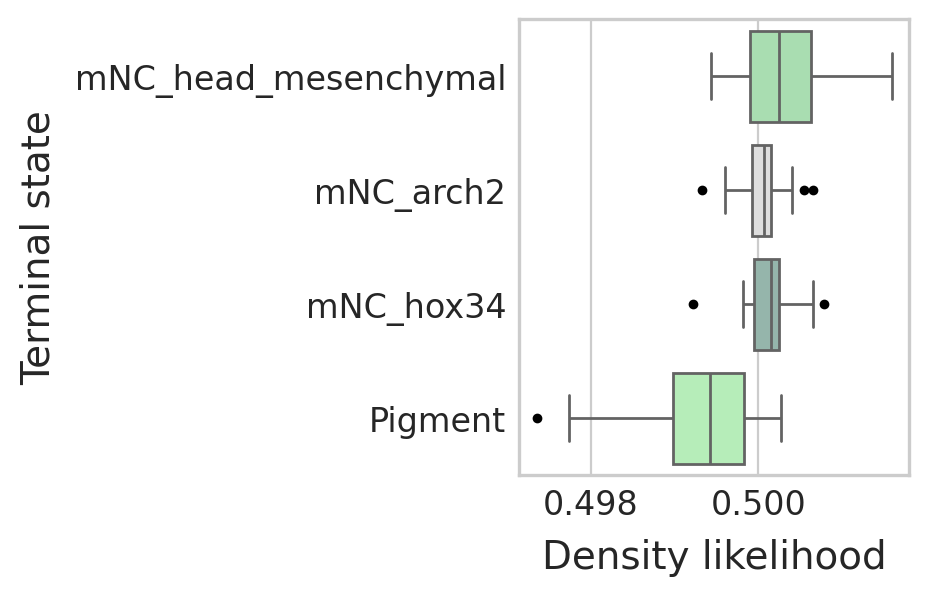

In [52]:
with mplscience.style_context():
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(2.5, 3))
    
    sns.boxplot(
        data=df,
        y="Group",
        x="Value",
        palette=palette_rel,
        ax=ax,
        flierprops={
            'marker': '.',
            'markersize': 5,
            'markerfacecolor': 'black',
            'markeredgecolor': 'black'
        }
    )
    ax.set_xlabel("Density likelihood")
    ax.set_ylabel("Terminal state")
    
    for spine in ax.spines.values():
        spine.set_visible(True)

    plt.show()

## Screening different KO combination

After completing all the steps above, the user can set parameters such as `n_states` in `rgv.tl.TFscreening` to perform end-to-end computations. This function also provides the `n_repeats` argument, which can be set to `n_repeats = 5` to run the model five times and obtain aggregated perturbation results for more stable estimations. In default we merely run model once.

In [53]:
KO_list = ["nr2f5", "elf1"]

perturb_likelihood, perturb_pval = rgv.tl.TFscreening(adata=adata,
                                                      prior_graph=W.T,
                                                      soft_constraint=False,
                                                      TF_list=TF,
                                                      cluster_label="cell_type",
                                                      terminal_states=TERMINAL_STATE,
                                                      KO_list=KO_list,
                                                      n_states=8,
                                                      cutoff=0)

training model...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:4

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2400.929. Signaling Trainer to stop.
save model...
inferring perturbation...
INFO     File                                                                                                      
         /ictstr01/groups/ml01/workspace/yifan.chen/regvelo_reproducibility/notebooks/tutorials/zebrafish/perturb_r
         epeat_runs/rgv_model_0/model.pt already downloaded                                                        


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /ictstr01/groups/ml01/workspace/yifan.chen/regvelo_reproducibility/notebooks/tutorials/zebrafish/perturb_r
         epeat_runs/rgv_model_0/model.pt already downloaded                                                        


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done nr2f5
INFO     File                                                                                                      
         /ictstr01/groups/ml01/workspace/yifan.chen/regvelo_reproducibility/notebooks/tutorials/zebrafish/perturb_r
         epeat_runs/rgv_model_0/model.pt already downloaded                                                        


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done elf1


In [54]:
2*(0.5 - perturb_likelihood)

,mNC_head_mesenchymal,mNC_arch2,mNC_hox34,Pigment
elf1,0.055707,0.078453,0.036037,-0.084455
nr2f5,-0.124248,0.068918,0.075752,0.058243
